In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from torchinfo import summary         
import numpy as np
import torchvision.transforms as tf
import transformers                    
from tensorboardX import SummaryWriter 
from pkg_resources import packaging    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from openTSNE import TSNE              
import pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import re
import time
import math
import decoder_models

import gc
import sys
from pympler import tracker
tr = tracker.SummaryTracker()
from torchvision import transforms

seed = 2023
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.benchmark = False  
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda')
cpu = torch.device('cpu')

In [ ]:
latent_code_model = torch.load('model_classification_resnet50_withoutfc.pth')

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names

train_nodes, _ = get_graph_node_names(latent_code_model)
for node in train_nodes:
    print(node)

input
0
1
2
3
4.0.conv1
4.0.bn1
4.0.relu
4.0.conv2
4.0.bn2
4.0.relu_1
4.0.conv3
4.0.bn3
4.0.downsample.0
4.0.downsample.1
4.0.add
4.0.relu_2
4.1.conv1
4.1.bn1
4.1.relu
4.1.conv2
4.1.bn2
4.1.relu_1
4.1.conv3
4.1.bn3
4.1.add
4.1.relu_2
4.2.conv1
4.2.bn1
4.2.relu
4.2.conv2
4.2.bn2
4.2.relu_1
4.2.conv3
4.2.bn3
4.2.add
4.2.relu_2
5.0.conv1
5.0.bn1
5.0.relu
5.0.conv2
5.0.bn2
5.0.relu_1
5.0.conv3
5.0.bn3
5.0.downsample.0
5.0.downsample.1
5.0.add
5.0.relu_2
5.1.conv1
5.1.bn1
5.1.relu
5.1.conv2
5.1.bn2
5.1.relu_1
5.1.conv3
5.1.bn3
5.1.add
5.1.relu_2
5.2.conv1
5.2.bn1
5.2.relu
5.2.conv2
5.2.bn2
5.2.relu_1
5.2.conv3
5.2.bn3
5.2.add
5.2.relu_2
5.3.conv1
5.3.bn1
5.3.relu
5.3.conv2
5.3.bn2
5.3.relu_1
5.3.conv3
5.3.bn3
5.3.add
5.3.relu_2
6.0.conv1
6.0.bn1
6.0.relu
6.0.conv2
6.0.bn2
6.0.relu_1
6.0.conv3
6.0.bn3
6.0.downsample.0
6.0.downsample.1
6.0.add
6.0.relu_2
6.1.conv1
6.1.bn1
6.1.relu
6.1.conv2
6.1.bn2
6.1.relu_1
6.1.conv3
6.1.bn3
6.1.add
6.1.relu_2
6.2.conv1
6.2.bn1
6.2.relu
6.2.conv2
6.2.bn2
6.

In [2]:
simple_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.Resize((224, 224)),# interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.RandomHorizontalFlip(),
    tf.Resize((224, 224)),# interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.RandomErasing(),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Reverse normalization for display
rev_tf = tf.Compose([
    tf.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
    tf.ConvertImageDtype(torch.uint8),
    tf.ToPILImage(),
])

In [3]:
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=train_tf)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=simple_tf)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [4]:
classification_model = torch.load('model_classification_resnet50_v2.pth')
classification_model.to(device)
print(classification_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for name, module in classification_model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [5]:
def ResNetActivations2(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output / output.norm()
            activations.append(output1.detach())
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [10]:
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["dog"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Mean normalised distances for layer 1: 0.13762028515338898
Mean normalised distances for layer 2: 0.07521015405654907
Mean normalised distances for layer 3: 0.0943976491689682
Mean normalised distances for layer 4: 0.11040719598531723
Mean normalised distances for layer 5: 0.1289381980895996


In [11]:
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["automobile"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.022103674709796906
Distance between centroids for layer 2: 0.009175066836178303
Distance between centroids for layer 3: 0.011061931028962135
Distance between centroids for layer 4: 0.01329062506556511
Distance between centroids for layer 5: 0.04122570902109146


In [5]:
layers = [  
            classification_model.conv1, 
            classification_model.layer1[0],
            classification_model.layer1[1],
            classification_model.layer1[2],
            classification_model.layer2[0],
            classification_model.layer2[1],
            classification_model.layer2[2],
            classification_model.layer2[3],
            classification_model.layer3[0],
            classification_model.layer3[1],
            classification_model.layer3[2],
            classification_model.layer3[3],
            classification_model.layer3[4],
            classification_model.layer3[5],
            classification_model.layer4[0],
            classification_model.layer4[1],
            classification_model.layer4[2],
            classification_model.fc
]

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0, 0.5, 'Normalised Centroid Distance')

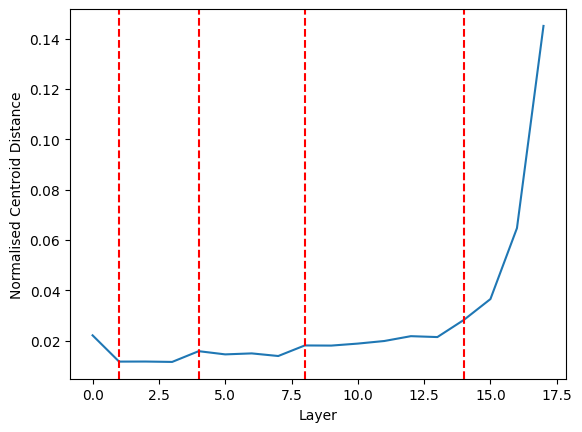

In [9]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["automobile"], classification_model, test_set, layers, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel("Layer")
ax.set_ylabel("Normalised Centroid Distance")

In [11]:
fig.savefig("figures/cifar10_distance_plot_automobile_cat.pdf")

In [14]:
distances[-1]

tensor(0.0816)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


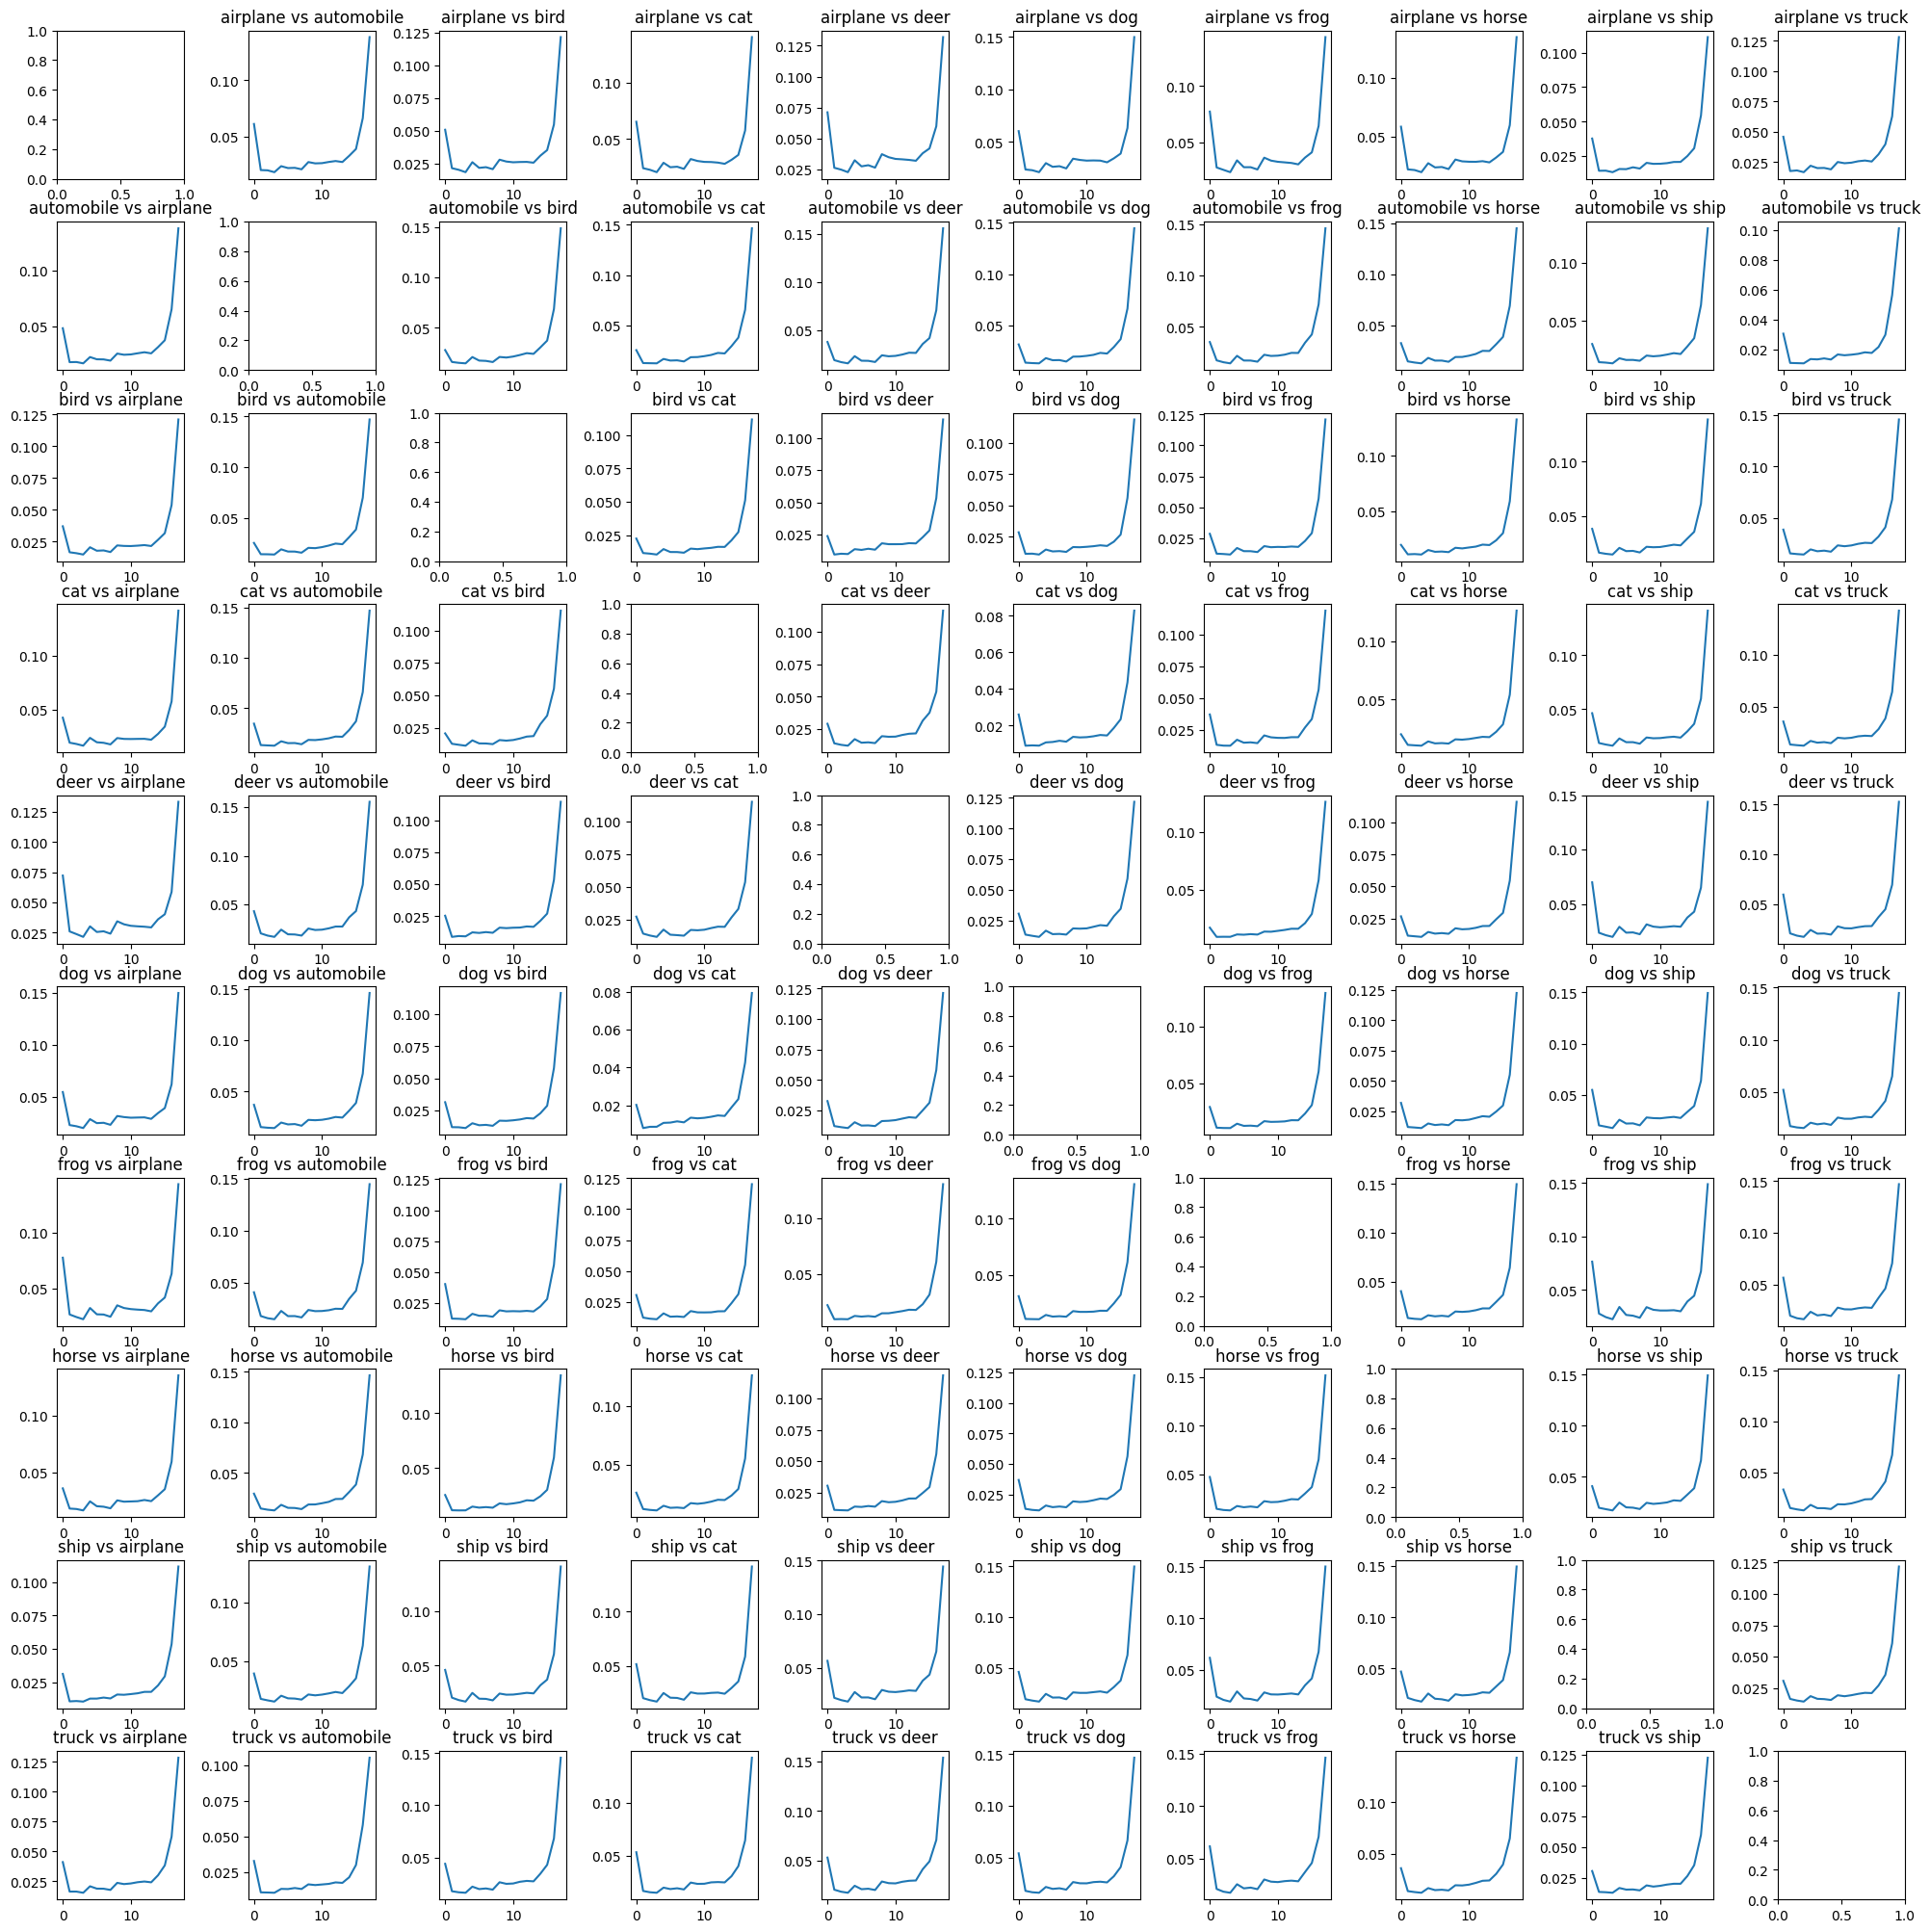

In [10]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations2(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_cifar10.pdf")

In [6]:
def ResNetActivations3(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output
            activations.append(output1.detach())
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [16]:
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["dog"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 0.9972387552261353
Mean normalised cosine distances for layer 2: 0.28104203939437866
Mean normalised cosine distances for layer 3: 0.44521814584732056
Mean normalised cosine distances for layer 4: 0.6082407236099243
Mean normalised cosine distances for layer 5: 0.8422763347625732


In [17]:
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["dog"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 1.156728982925415
Cosine Distance between centroids for layer 2: 0.0044422149658203125
Cosine Distance between centroids for layer 3: 0.008773446083068848
Cosine Distance between centroids for layer 4: 0.019796669483184814
Cosine Distance between centroids for layer 5: 0.3917195200920105


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0, 0.5, 'Mean Cosine Distance')

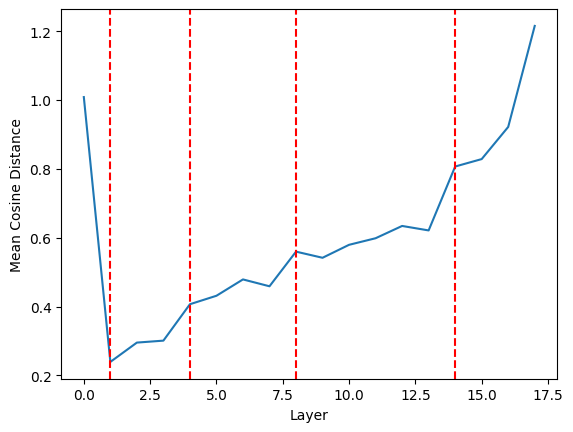

In [7]:
fig, ax = plt.subplots()
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations3(train_set.class_to_idx["automobile"], classification_model, test_set, layers, n_points=100)
distances_arr = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    cos_distance = 1 - distance.mean()
    distances_arr.append(cos_distance.to(cpu))
    del act1, act2
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances_arr)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel("Layer")
ax.set_ylabel("Mean Cosine Distance")

In [8]:
fig.savefig("figures/cifar10_cosine_distance_plot_automobile_cat.pdf")

In [14]:
fig.savefig("figures/cifar10_cosine_distance_plot_automobile_cat.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


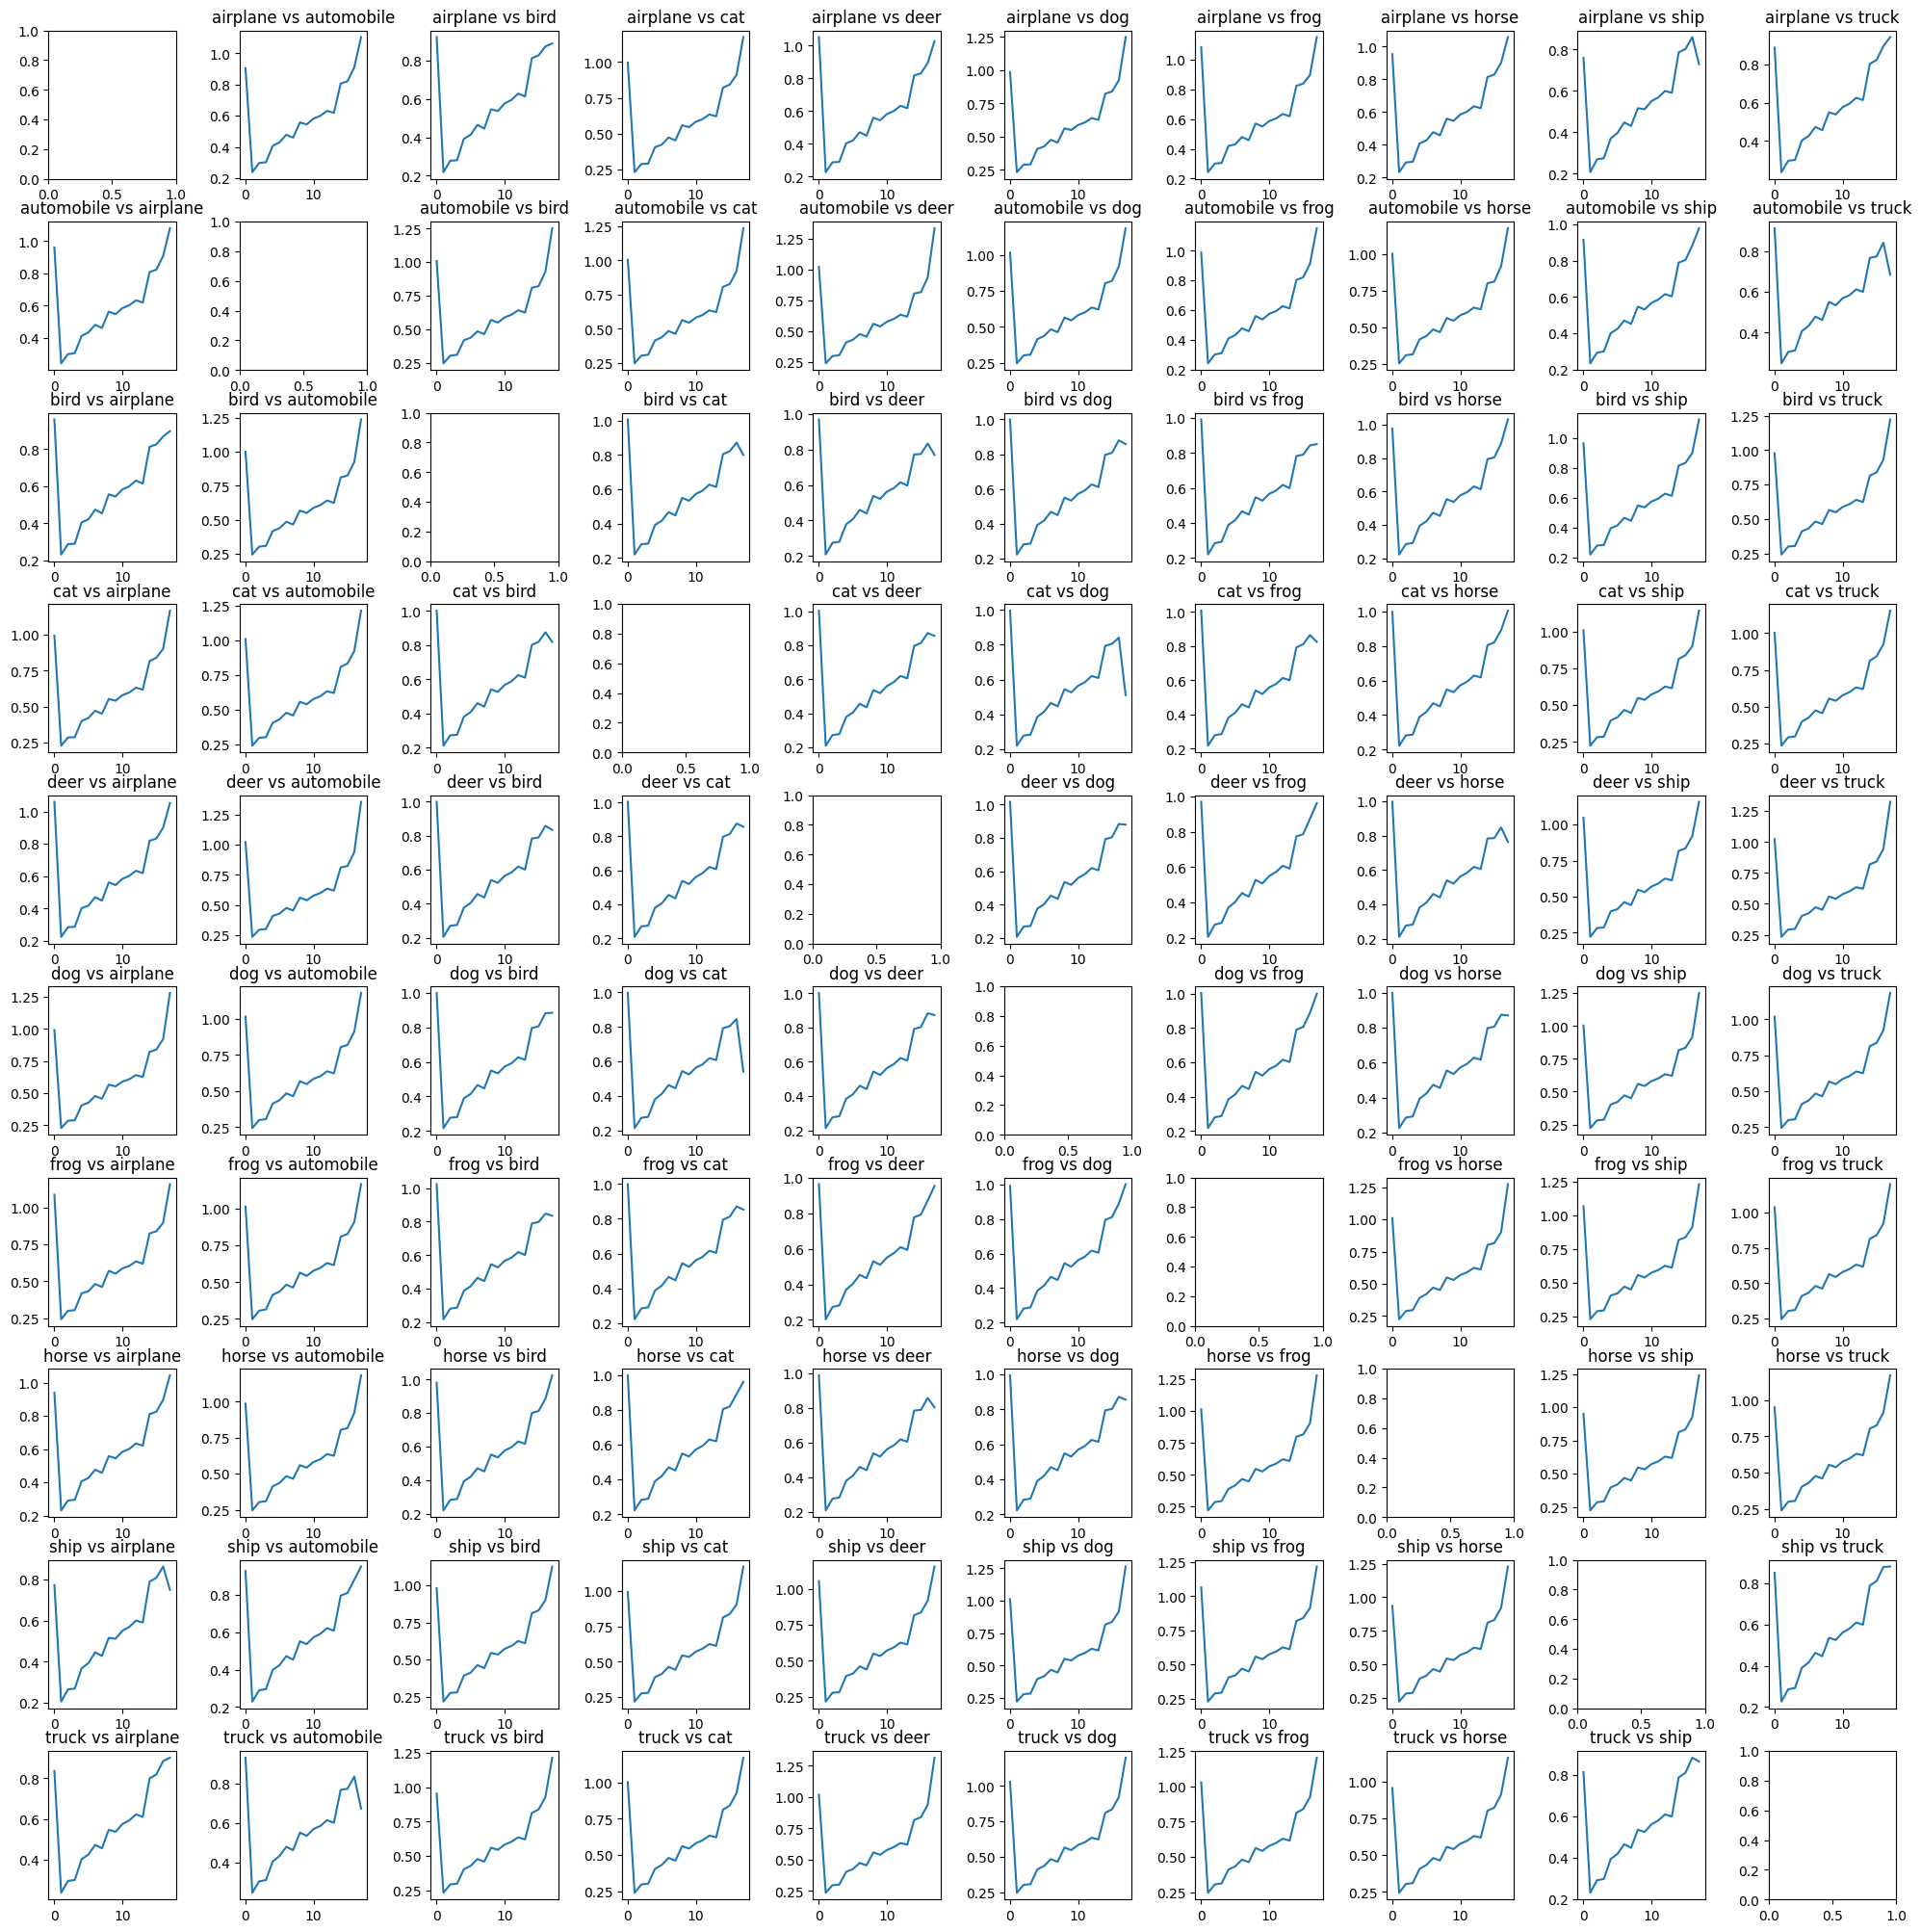

In [10]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations3(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
            cos_distance = 1 - distance.mean()
            distances.append(cos_distance.to(cpu))
            del act1, act2
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()

In [11]:
fig.savefig("figures/cosine_distances_cifar10.pdf")

In [9]:
classification_model2 = torch.load('model_classification_resnet50_1_epoch.pth')
classification_model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["dog"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised distances for layer 1: 0.13784928619861603
Mean normalised distances for layer 2: 0.07603784650564194
Mean normalised distances for layer 3: 0.09535963833332062
Mean normalised distances for layer 4: 0.11036451160907745
Mean normalised distances for layer 5: 0.13752304017543793


In [21]:
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["dog"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.021562103182077408
Distance between centroids for layer 2: 0.007965399883687496
Distance between centroids for layer 3: 0.009994004853069782
Distance between centroids for layer 4: 0.012101850472390652
Distance between centroids for layer 5: 0.018092801794409752


In [10]:
layers2 = [  
            classification_model2.conv1, 
            classification_model2.layer1[0],
            classification_model2.layer1[1],
            classification_model2.layer1[2],
            classification_model2.layer2[0],
            classification_model2.layer2[1],
            classification_model2.layer2[2],
            classification_model2.layer2[3],
            classification_model2.layer3[0],
            classification_model2.layer3[1],
            classification_model2.layer3[2],
            classification_model2.layer3[3],
            classification_model2.layer3[4],
            classification_model2.layer3[5],
            classification_model2.layer4[0],
            classification_model2.layer4[1],
            classification_model2.layer4[2],
            classification_model2.fc
]

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0, 0.5, 'Normalised Centroid Distance')

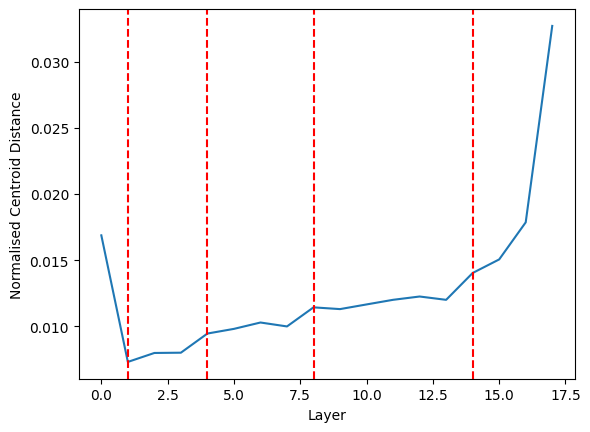

In [17]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["cat"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["dog"], classification_model2, test_set, layers2, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel("Layer")
ax.set_ylabel("Normalised Centroid Distance")

In [18]:
fig.savefig("figures/cifar10_distance_plot_automobile_cat_1_epoch.pdf")

In [24]:
distances[-1]

tensor(0.0326)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


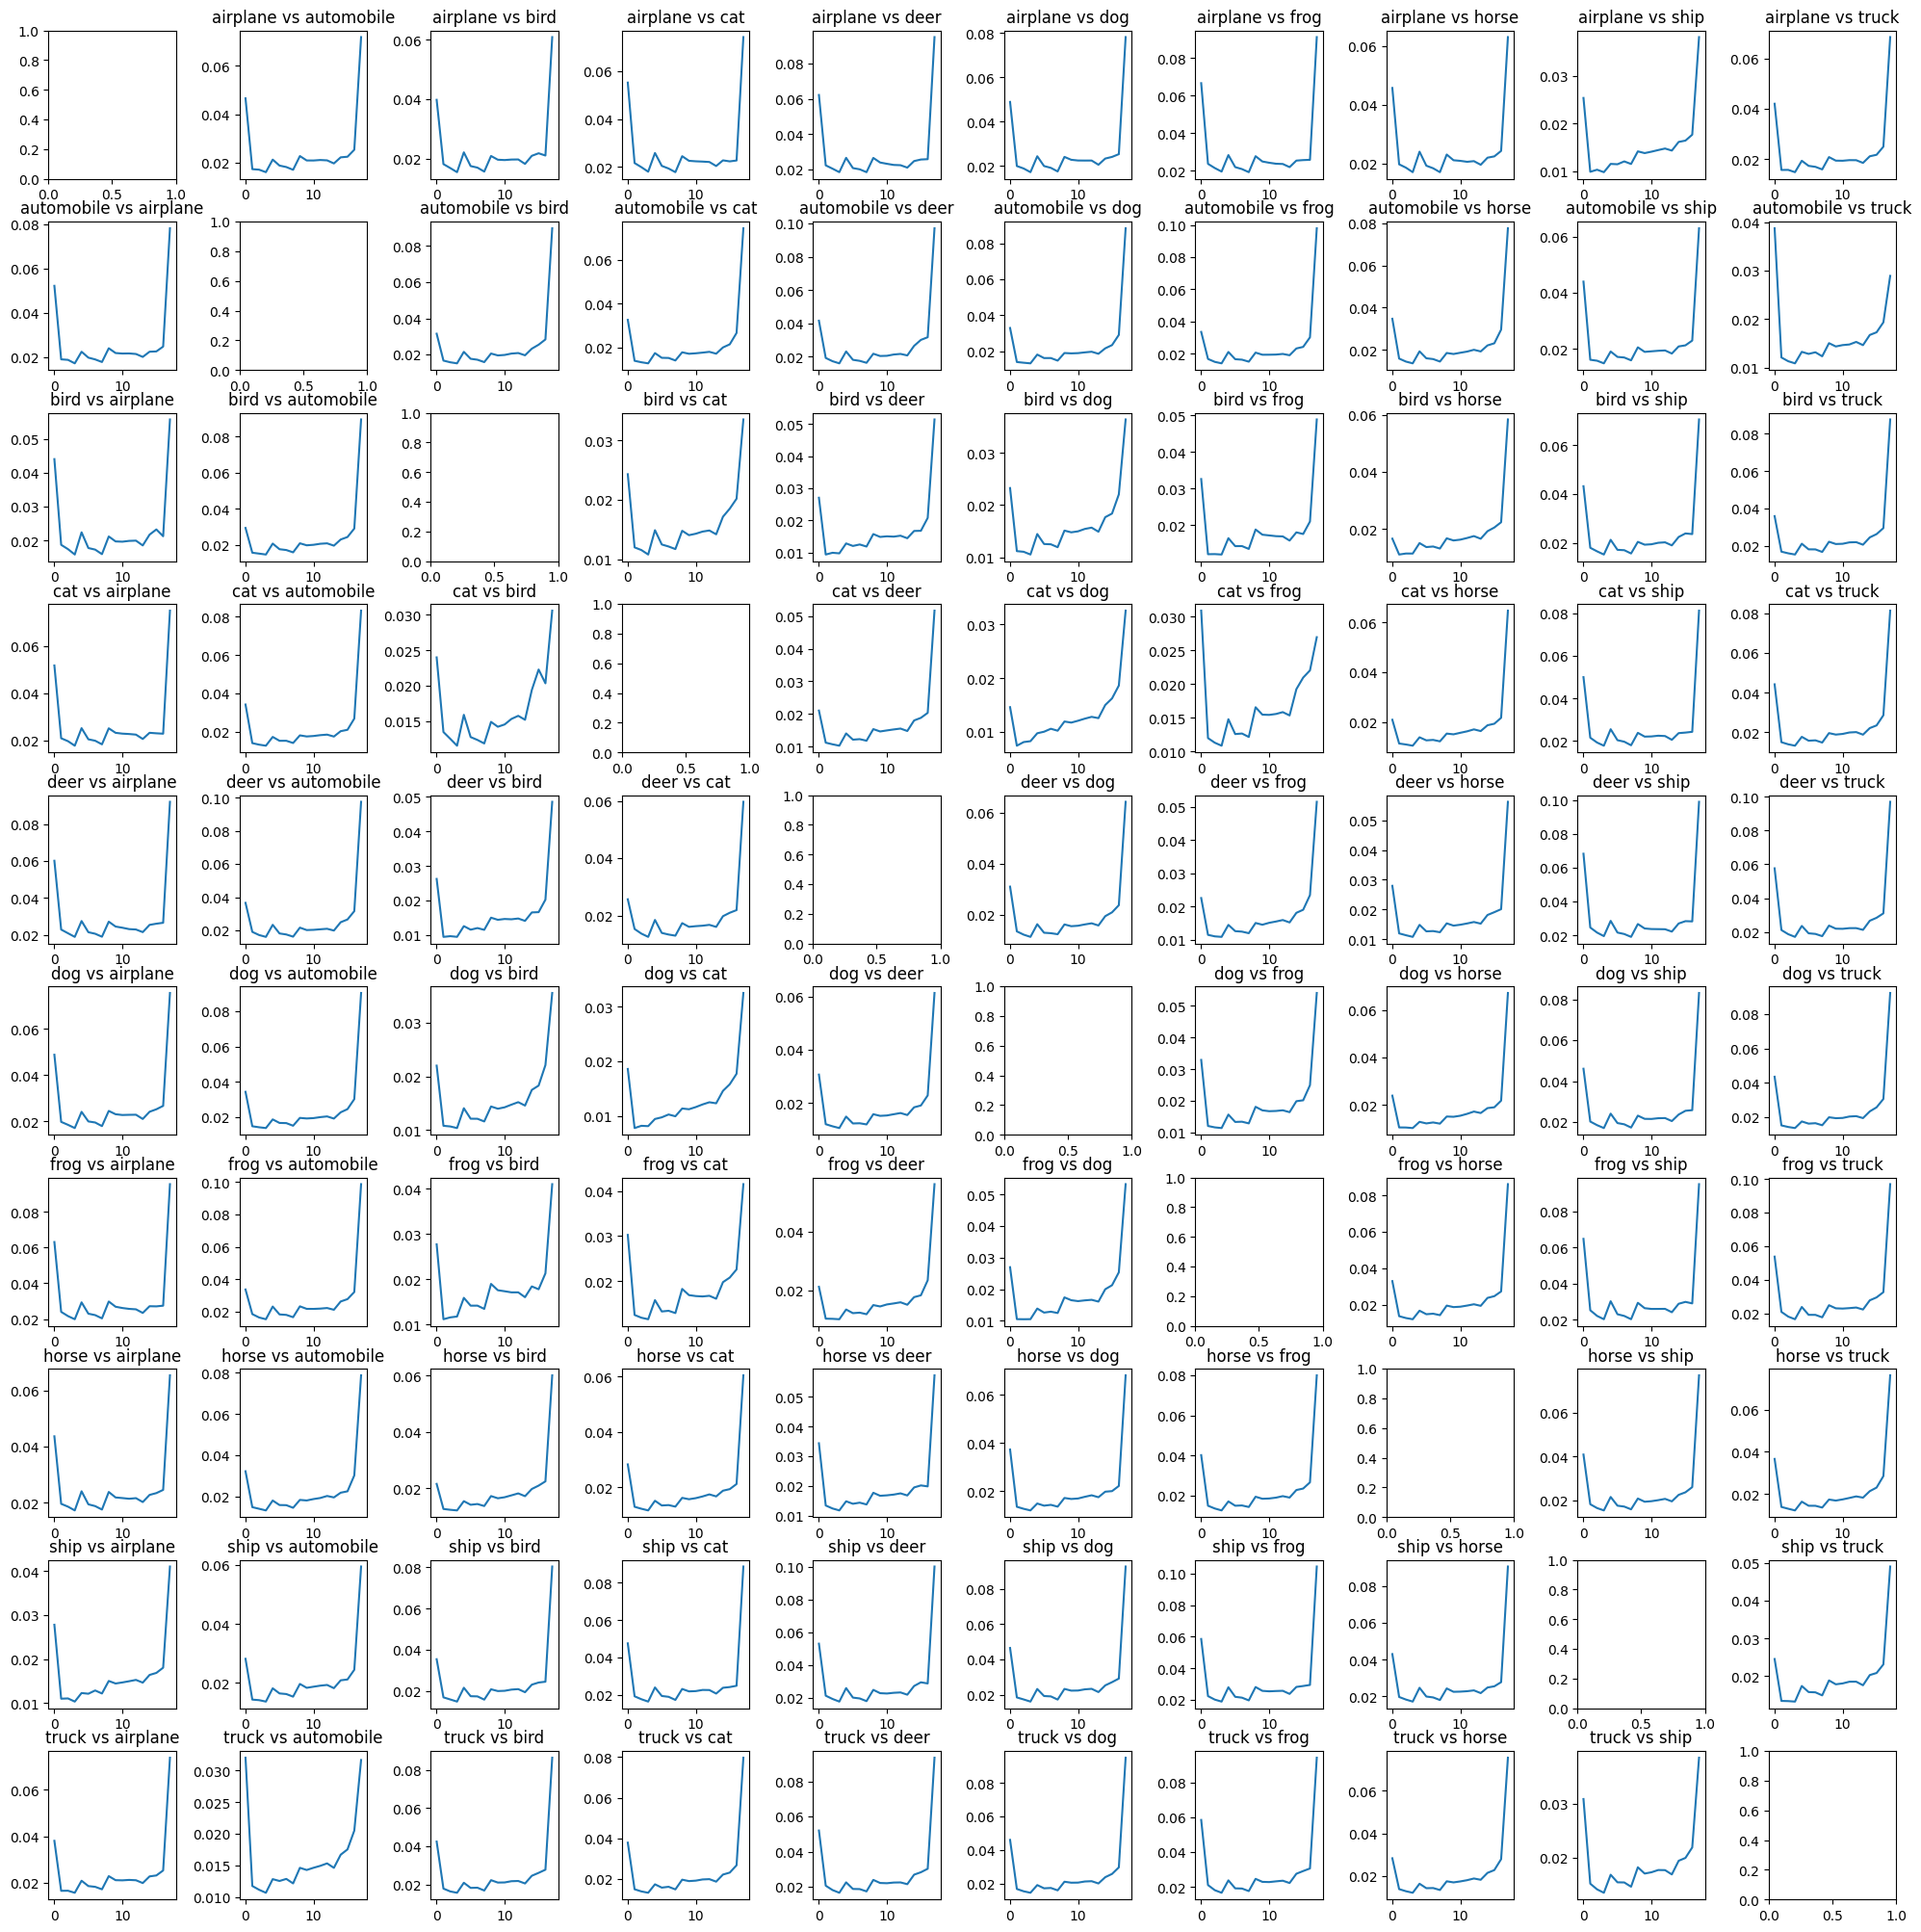

In [13]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations2(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_cifar10_1_epoch.pdf")

In [25]:
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["dog"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 0.9926794767379761
Mean normalised cosine distances for layer 2: 0.28722572326660156
Mean normalised cosine distances for layer 3: 0.45183801651000977
Mean normalised cosine distances for layer 4: 0.6098492741584778
Mean normalised cosine distances for layer 5: 0.9551365375518799


In [26]:
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["dog"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 0.6386799216270447
Cosine Distance between centroids for layer 2: 0.0048323869705200195
Cosine Distance between centroids for layer 3: 0.009277939796447754
Cosine Distance between centroids for layer 4: 0.020551323890686035
Cosine Distance between centroids for layer 5: 0.28836190700531006


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0, 0.5, 'Normalised Centroid Distance')

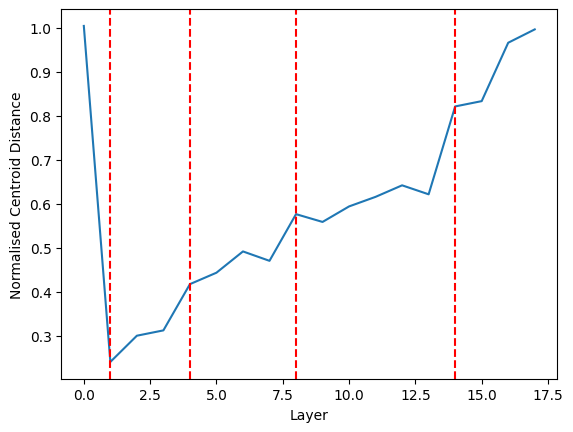

In [21]:
fig, ax = plt.subplots()
activations1 = ResNetActivations3(train_set.class_to_idx["cat"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations3(train_set.class_to_idx["automobile"], classification_model2, test_set, layers2, n_points=100)

distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    cos_distance = 1 - distance.mean()
    distances.append(cos_distance.to(cpu))
    del act1, act2
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers2)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel("Layer")
ax.set_ylabel("Normalised Centroid Distance")

In [22]:
fig.savefig("figures/cifar10_cosine_distance_plot_automobile_cat_1_epoch.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


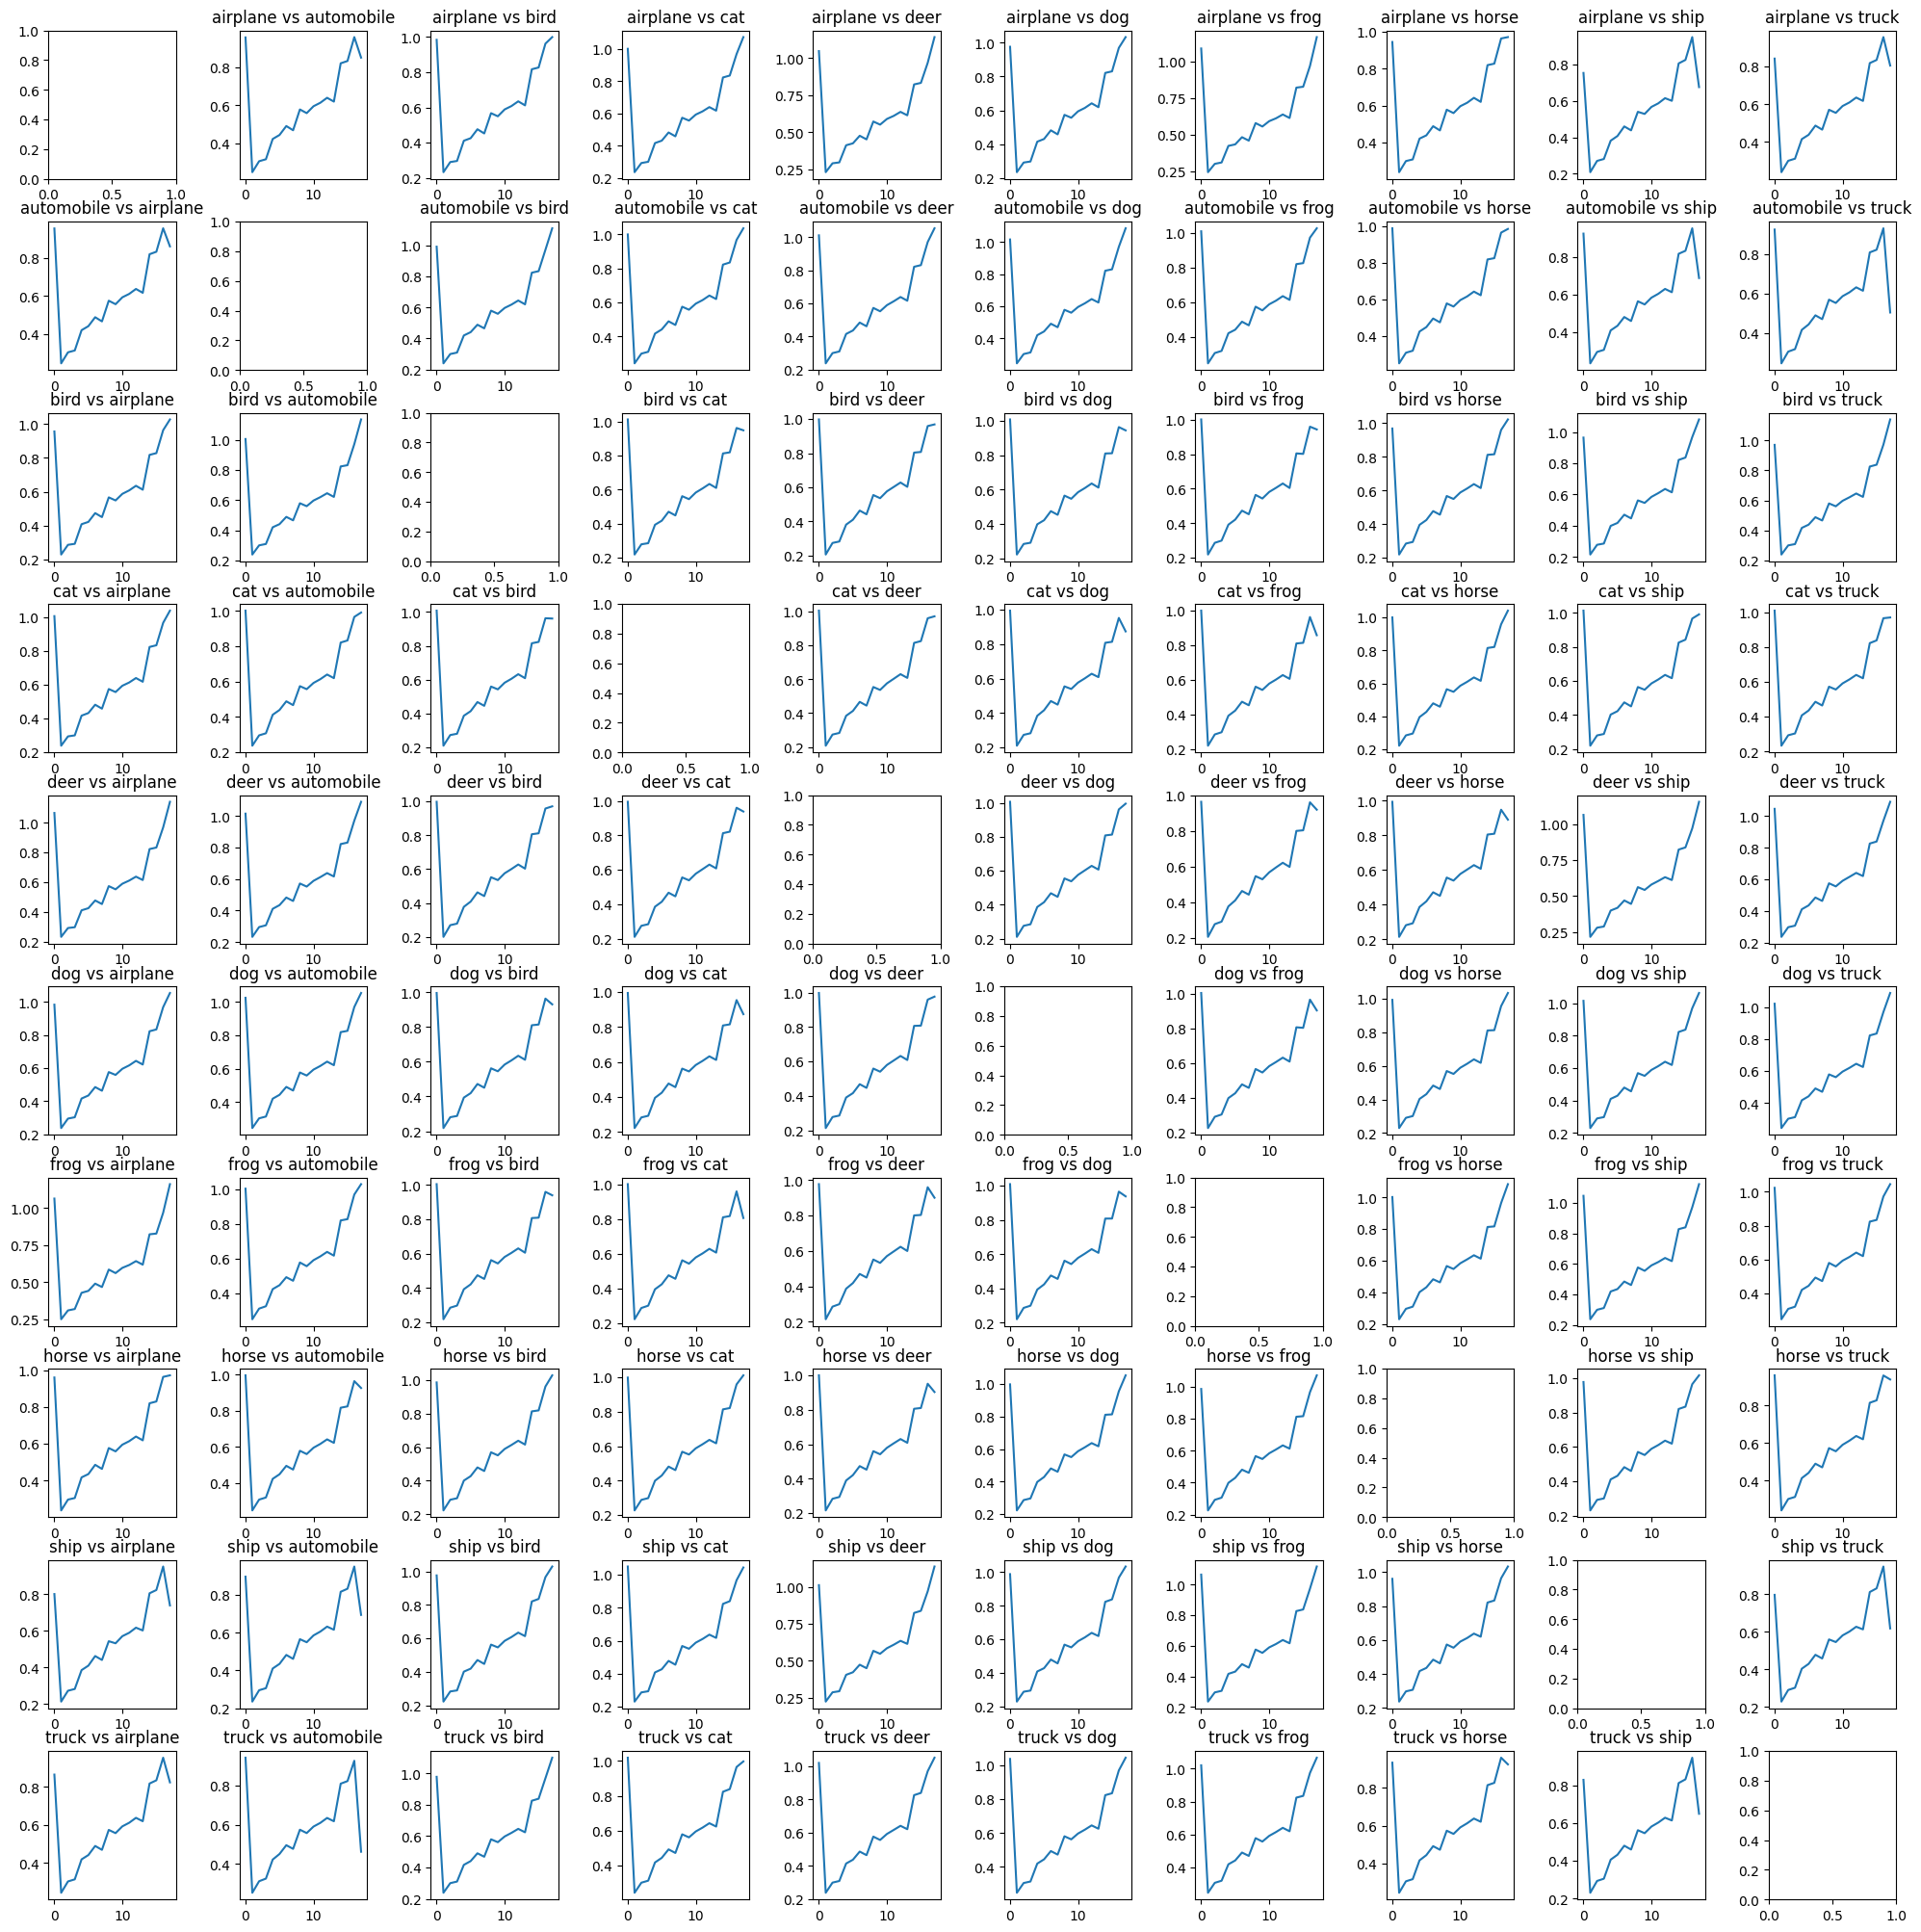

In [16]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations3(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
            cos_distance = 1 - distance.mean()
            distances.append(cos_distance.to(cpu))
            del act1, act2
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers2)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/cosine_distances_cifar10_1_epoch.pdf")

In [6]:
class SplitResNet(nn.Module):
    def __init__(self, model, layer_hierarchy):
        super(SplitResNet, self).__init__()
        # self.model = model
        self.part1 = nn.Sequential()
        self.part2 = nn.Sequential()

        for i, (name, module) in enumerate(model.named_children()):
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    self.part1.add_module(name, module)
                else:
                    former_module, latter_module = self._add_module(module, layer_hierarchy[1:])
                    self.part1.add_module(name, former_module)
                    self.part2.add_module(name, latter_module)
            elif i < layer_hierarchy[0]:
                self.part1.add_module(name, module)
            else:
                self.part2.add_module(name, module)

    def _add_module(self, module, layer_hierarchy):
        # print(layer_hierarchy, module)
        former_module, latter_module = nn.Sequential(), nn.Sequential()
        for i, (name, layer) in enumerate(module.named_children()):
            # print(name)
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    # print('check')
                    former_module.add_module(name, layer)
                else:
                    # print('run')
                    former_layer, latter_layer = self._add_module(layer, layer_hierarchy[1:])
                    former_module.add_module(name, former_layer)
                    latter_module.add_module(name, latter_layer)
            elif i < layer_hierarchy[0]:
                former_module.add_module(name, layer)
            else:
                latter_module.add_module(name, layer)
        return former_module, latter_module

    def forward(self, x, mode='latter'):
        for module in self.part2[:-1]:
            x = module(x)
        x = torch.flatten(x, 1)
        return self.part2[-1](x)
        # if mode == 'latter':
        #     return self.part2(x)
        # if mode == 'former':
        #     return self.part1(x)
        # if mode == 'all_as_one_model':
        #     x = self.part1(x)
        #     x1 = self.part2(x)
        #     return x, x1
        # if mode == 'all_as_two_model':
        #     return self.part1(x), self.part2(x)

In [6]:
split_model = SplitResNet(classification_model, [7])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 3]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolated_activation = activation1 + (activation2 - activation1)*0.5
output1 = split_model(interpolated_activation)
label = output1.argmax().item()
print(f"Interpolated label: {label}")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Interpolated label: 3


In [7]:
split_model = SplitResNet(classification_model, [4])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 7]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolation_weights = torch.linspace(0, 1, 10).to(device)
interpolated_labels = []
for weight in interpolation_weights:
    interpolated_activation = torch.lerp(activation1, activation2, weight)
    output1 = split_model(interpolated_activation)
    label = output1.argmax().item()
    interpolated_labels.append(label)
print(all([label == interpolated_labels[0] for label in interpolated_labels]))
print(interpolated_labels)

False
[7, 7, 7, 5, 3, 4, 4, 7, 7, 0]


In [8]:
def class_convexity(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [7]:
def class_convexity2(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model2, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model2(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model2(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [9]:
print(class_convexity(5, 4))
torch.cuda.empty_cache()

0.32


In [10]:
for i in range(9):
    print(f"Class 0, layer {i}: {class_convexity(0, i)}")

Class 0, layer 0: 0.76
Class 0, layer 1: 0.76
Class 0, layer 2: 0.84
Class 0, layer 3: 0.84
Class 0, layer 4: 0.56
Class 0, layer 5: 0.68
Class 0, layer 6: 0.92
Class 0, layer 7: 0.92
Class 0, layer 8: 1.0


In [18]:
for i in range(9):
    print(f"Class 1, layer {i}: {class_convexity(1, i)}")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Class 1, layer 0: 0.68
Class 1, layer 1: 0.76
Class 1, layer 2: 0.48
Class 1, layer 3: 0.8
Class 1, layer 4: 0.72
Class 1, layer 5: 0.8
Class 1, layer 6: 0.96
Class 1, layer 7: 0.96
Class 1, layer 8: 0.92


In [19]:
for i in range(9):
    print(f"Class 2, layer {i}: {class_convexity(2, i)}")

Class 2, layer 0: 0.64
Class 2, layer 1: 0.52
Class 2, layer 2: 0.72
Class 2, layer 3: 0.76
Class 2, layer 4: 0.88
Class 2, layer 5: 0.64
Class 2, layer 6: 0.84
Class 2, layer 7: 0.92
Class 2, layer 8: 0.96


In [20]:
for i in range(9):
    print(f"Class 3, layer {i}: {class_convexity(3, i)}")

Class 3, layer 0: 0.56
Class 3, layer 1: 0.72
Class 3, layer 2: 0.84
Class 3, layer 3: 0.84
Class 3, layer 4: 0.56
Class 3, layer 5: 0.6
Class 3, layer 6: 0.92
Class 3, layer 7: 1.0
Class 3, layer 8: 0.96


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


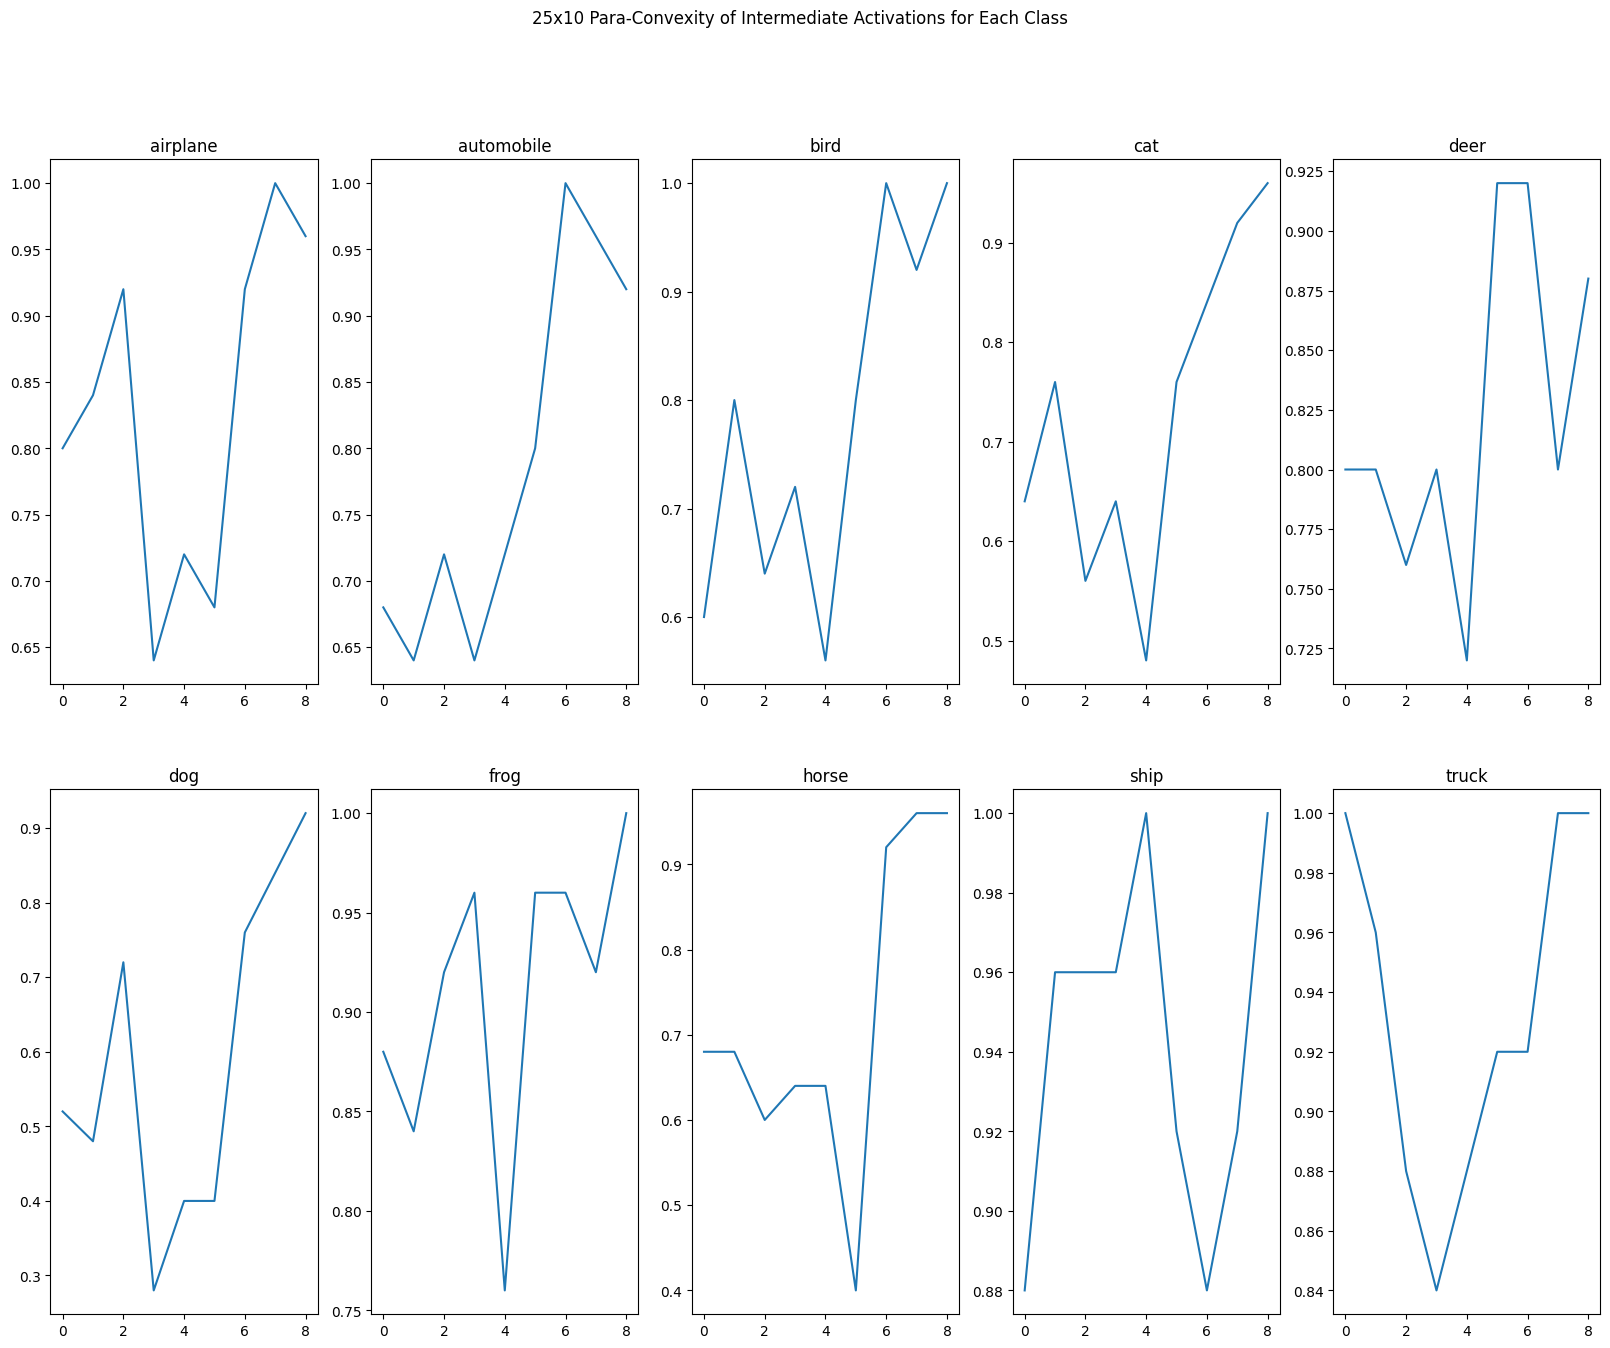

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
#fig.tight_layout()
fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")
for i in range(10):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    ax[row, col].plot(range(9), [class_convexity(i, j) for j in range(9)])
    ax[row, col].set_title(class_name)

In [11]:
fig.savefig("figures/para_convexity_cifar10.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


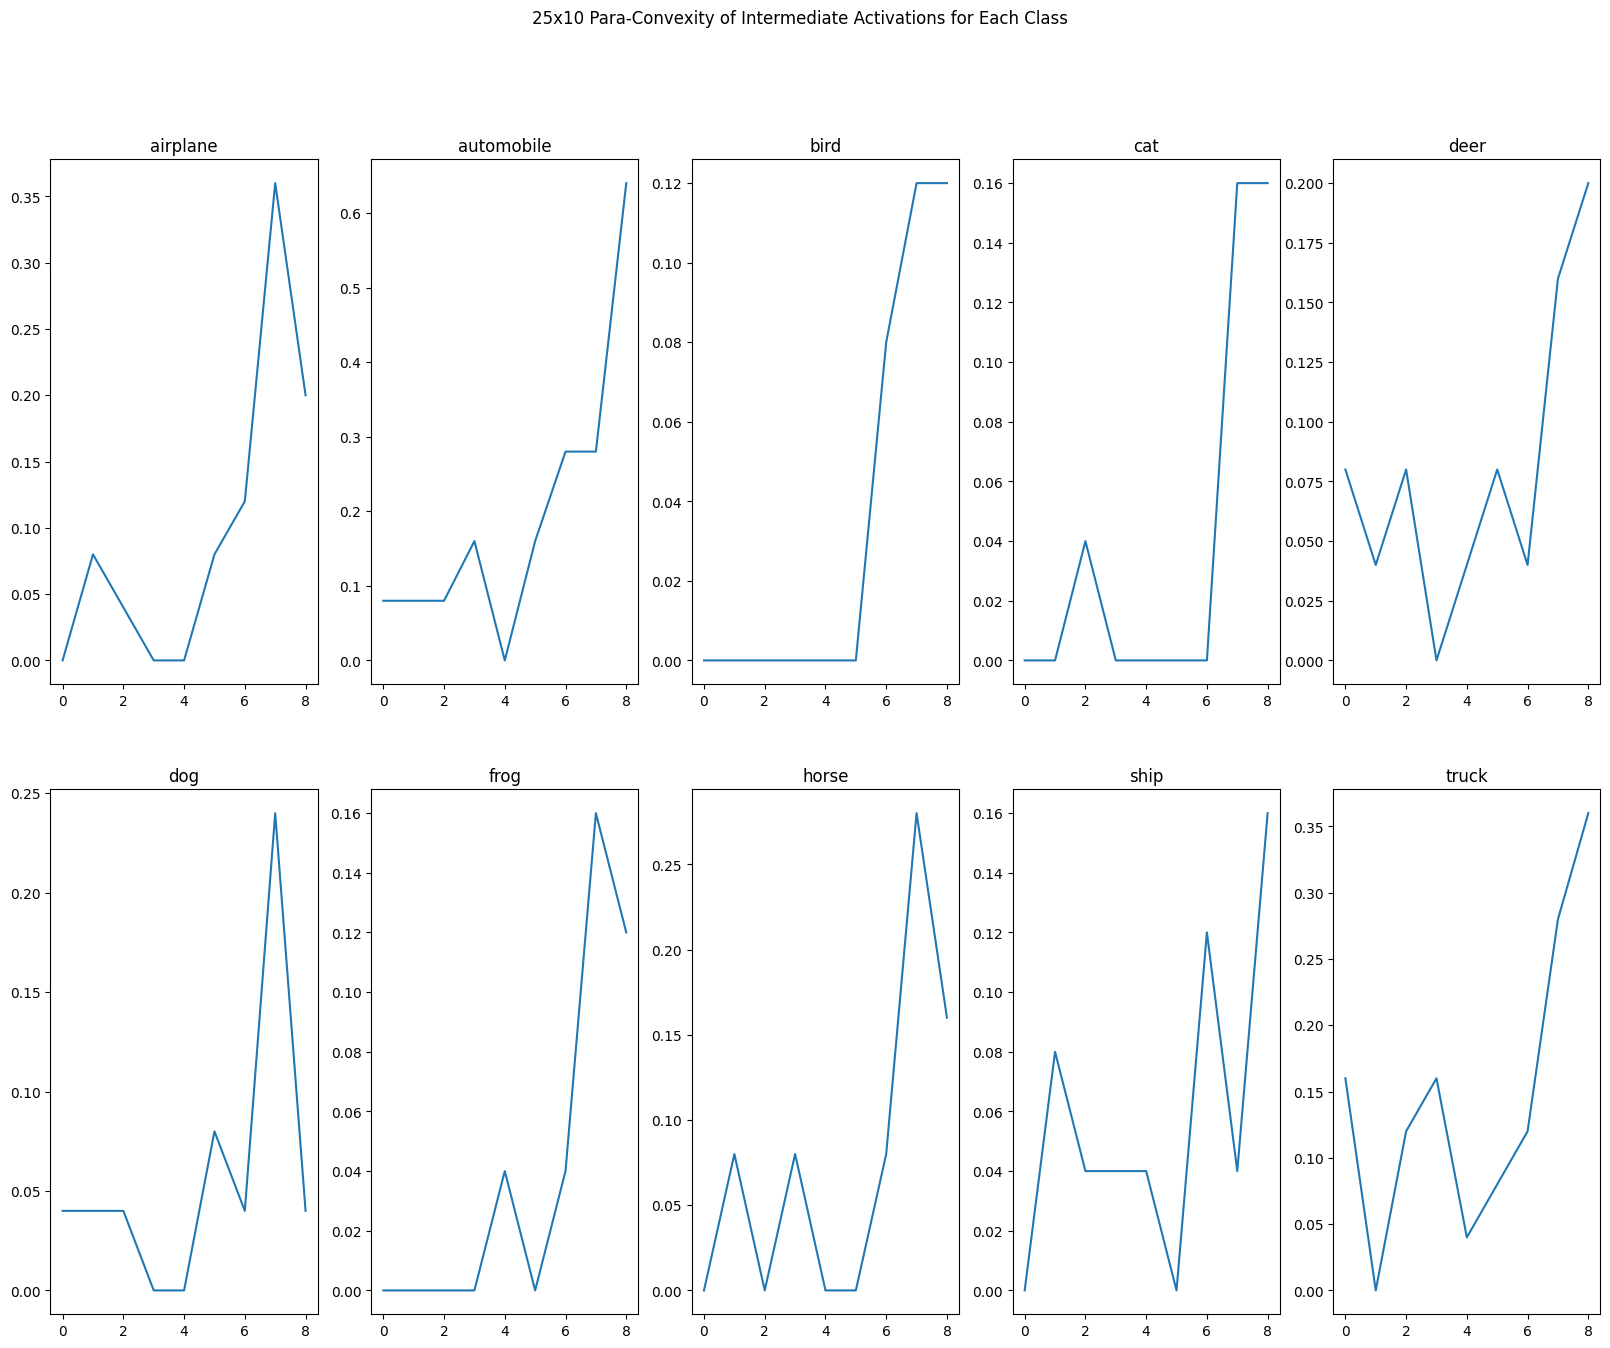

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
#fig.tight_layout()
fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")

for i in range(10):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    ax[row, col].plot(range(9), [class_convexity2(i, j) for j in range(9)])
    ax[row, col].set_title(class_name)

In [9]:
fig.savefig("figures/para_convexity_cifar10_1_epoch.pdf")

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [7]:
from torch.utils.data import Subset, DataLoader

# Define the number of samples to be taken from each class
num_samples_per_class = 15

# Create a list to store the indices of the selected samples
selected_indices = []

# Iterate over each class
for class_label in range(10):
    # Get the indices of samples belonging to the current class
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == class_label]
    
    # Randomly select num_samples_per_class indices from the class_indices
    selected_indices.extend(torch.randperm(len(class_indices))[:num_samples_per_class])

# Create a Subset of the train_set using the selected indices
subset = Subset(train_set, selected_indices)

# Create a DataLoader to load the subset into a batch
batch_size = 150 # 25 samples from each class, total 250 samples
data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
activations = []
hook = classification_model.fc.register_forward_hook(lambda self, input, output: activations.append(output))
for batch, labels in data_loader:
    classification_model(batch.to(device))
hook.remove()

In [9]:
activations = activations[0].view(activations[0].size(0), -1)

In [10]:
import umap

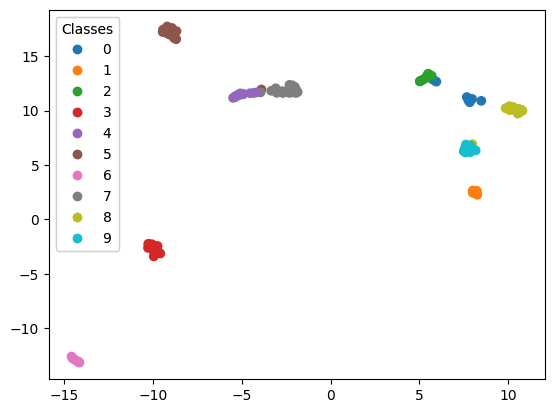

In [11]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_activations = umap_model.fit_transform(activations.detach().to(cpu))

fig, ax = plt.subplots()
scatter = ax.scatter(umap_activations[:, 0], umap_activations[:, 1], c=labels, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), title='Classes')
ax.add_artist(legend)

In [9]:
del activations
torch.cuda.empty_cache()

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

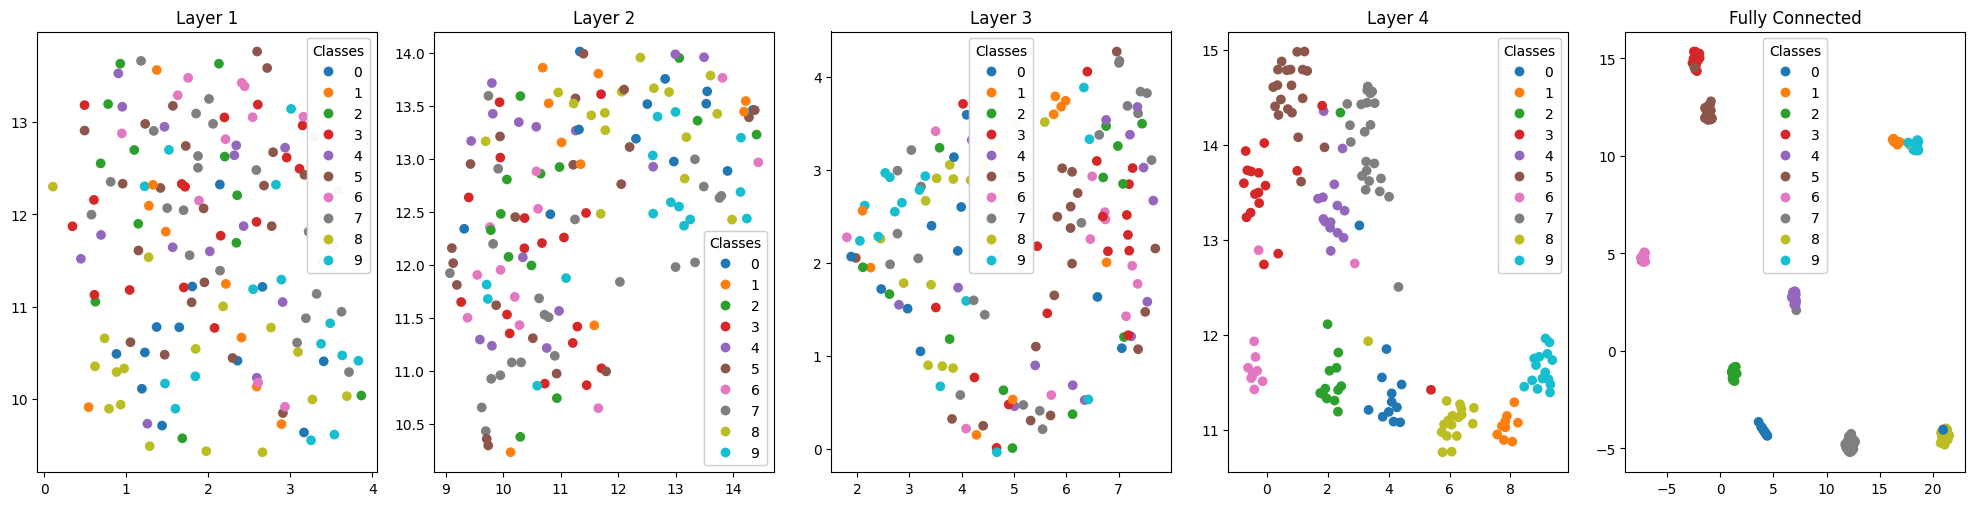

In [13]:
layers_arr = [classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4, classification_model.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()
for i, layer in enumerate(layers_arr):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    scatter = ax[i].scatter(umap_activations[:, 0], umap_activations[:, 1], c=labels, cmap='tab10')
    legend = ax[i].legend(*scatter.legend_elements(), title='Classes')
    ax[i].add_artist(legend)
    ax[i].set_title(f"Layer {i+1}" if i < 4 else "Fully Connected")
    #ax[i].axis('off')
    #ax[i].set_aspect('equal')
    del activations
    torch.cuda.empty_cache()

In [14]:
fig.savefig("figures/umap_cifar10_layers.pdf")

In [10]:
import umap

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

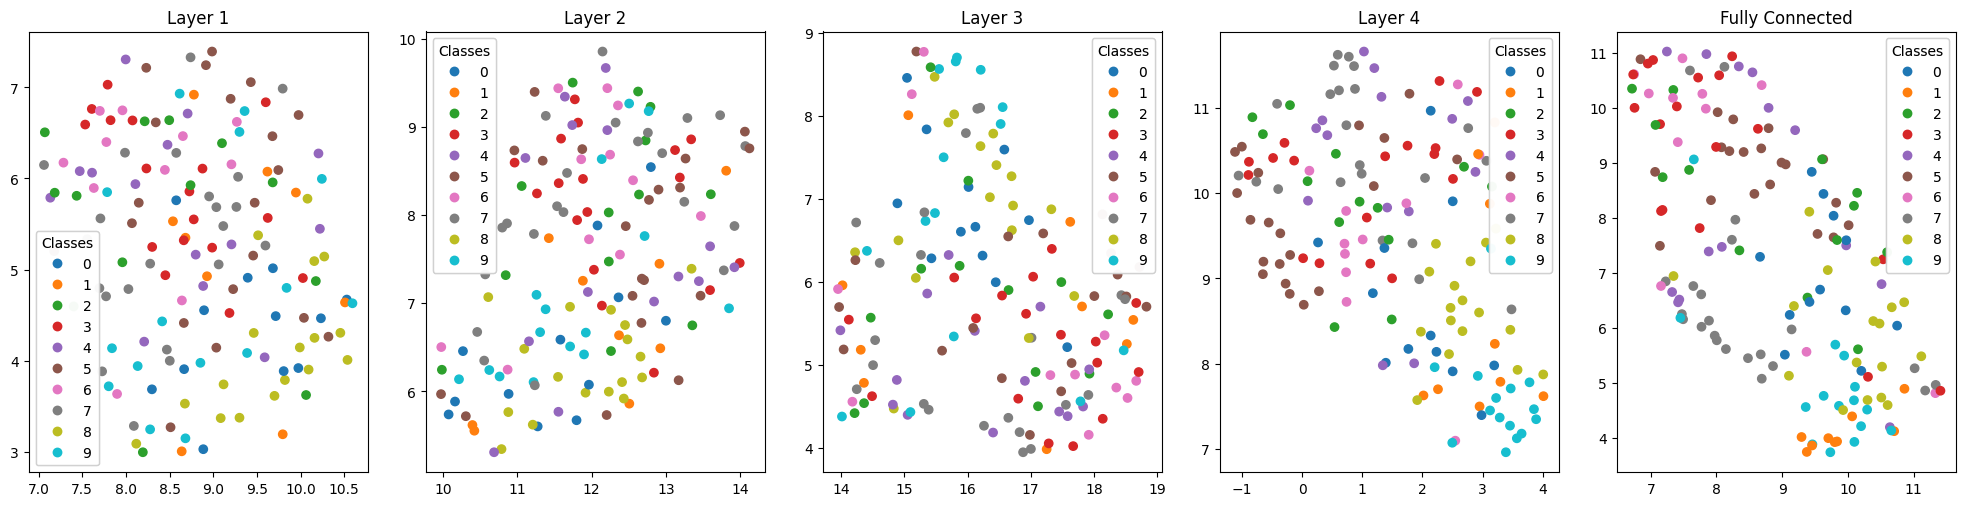

In [11]:
layers_arr2 = [classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4, classification_model2.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()

for i, layer in enumerate(layers_arr2):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model2(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    scatter = ax[i].scatter(umap_activations[:, 0], umap_activations[:, 1], c=labels, cmap='tab10')
    legend = ax[i].legend(*scatter.legend_elements(), title='Classes')
    ax[i].add_artist(legend)
    ax[i].set_title(f"Layer {i+1}" if i < 4 else "Fully Connected")
    #ax[i].axis('off')
    #ax[i].set_aspect('equal')
    del activations
    torch.cuda.empty_cache()

In [12]:
fig.savefig("figures/umap_cifar10_layers_1_epoch.pdf")